In [1]:
import torch
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL
from PIL import Image
import copy

from ip_adapter.ip_adapter_faceid import IPAdapterFaceIDPlus, IPAdapterFaceID
from insightface.app import FaceAnalysis
from insightface.model_zoo.arcface_onnx import ArcFaceONNX
from insightface.utils import face_align
from numpy.linalg import norm as l2norm
import cv2
from ip_adapter.utils import register_cross_attention_hook, get_net_attn_map, attnmaps2images

/root/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/root/anaconda3/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/root/anaconda3/lib/python3.9/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/root/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion

In [2]:
app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

v2 = False
base_model_path = "SG161222/Realistic_Vision_V4.0_noVAE"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "IP-Adapter/models/image_encoder/"
plus_ip_ckpt = "IP-Adapter-FaceID/ip-adapter-faceid-plusv2_sd15.bin"
ip_ckpt = "IP-Adapter-FaceID/ip-adapter-faceid_sd15.bin"
device = "cuda"

/root/anaconda3/lib/python3.9/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [3]:
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)
pipe.unet = register_cross_attention_hook(pipe.unet)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# generate image
prompt = "photo of a woman in red dress in a garden, white hair, happy"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, blurry"

import wandb
table = wandb.Table(columns=["prompt", "scale", "face", "gen"])

def rtn_face_get(self, img, face):
    aimg = face_align.norm_crop(img, landmark=face.kps, image_size=self.input_size[0])
    #print(cv2.imwrite("aimg.png", aimg))
    face.embedding = self.get_feat(aimg).flatten()
    face.crop_face = aimg
    return face.embedding

ArcFaceONNX.get = rtn_face_get
image = cv2.imread("assets/images/woman.png")
faces = app.get(image)
faceid_embeds = faces[0].normed_embedding
faceid_embeds = torch.from_numpy(faceid_embeds).unsqueeze(0)
face_image = faces[0].crop_face

/root/anaconda3/lib/python3.9/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


In [5]:
plus_ip_model = IPAdapterFaceIDPlus(copy.deepcopy(pipe), image_encoder_path, plus_ip_ckpt, device)
images = plus_ip_model.generate(
    prompt=prompt,
    negative_prompt=negative_prompt,
    face_image=face_image,
    faceid_embeds=faceid_embeds,
    shortcut=v2,
    s_scale=1,
    num_samples=1,
    width=512, height=768,
    num_inference_steps=30, seed=2023
)

  0%|          | 0/30 [00:00<?, ?it/s]

In [6]:
attn_maps = get_net_attn_map((768, 512))
print(attn_maps.shape)
attn_hot = attnmaps2images(attn_maps)


torch.Size([4, 768, 512])


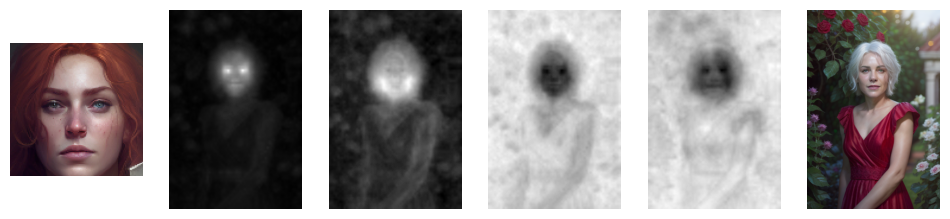

In [8]:
import matplotlib.pyplot as plt
#axes[0].imshow(attn_hot[0], cmap='gray')
display_images = [cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)] + attn_hot + [images[0]]
fig, axes = plt.subplots(1, len(display_images), figsize=(12, 4))
for axe, image in zip(axes, display_images):
    axe.imshow(image, cmap='gray')
    axe.axis('off')
plt.show()

In [9]:
ip_model = IPAdapterFaceID(copy.deepcopy(pipe), ip_ckpt, device)
images = ip_model.generate(
    prompt=prompt, negative_prompt=negative_prompt,
    faceid_embeds=faceid_embeds,
    num_samples=1,
    width=512, height=768,
    num_inference_steps=30, seed=2023
)

  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
attn_maps = get_net_attn_map((768, 512))
print(attn_maps.shape)
attn_hot = attnmaps2images(attn_maps)

torch.Size([4, 768, 512])


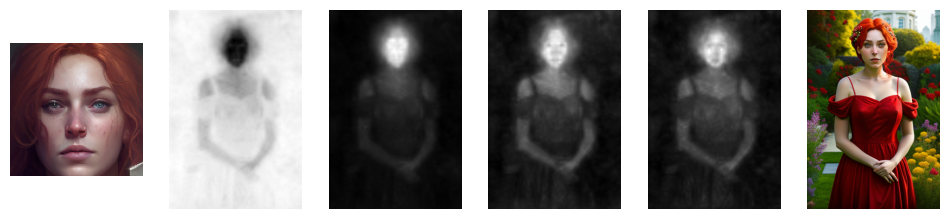

In [11]:

display_images = [cv2.cvtColor(face_image, cv2.COLOR_BGR2RGB)] + attn_hot + [images[0]]
fig, axes = plt.subplots(1, len(display_images), figsize=(12, 4))
for axe, image in zip(axes, display_images):
    axe.imshow(image, cmap='gray')
    axe.axis('off')
plt.show()